# Emcee GP Study

An emcee sampler notebook, testing various things about the emcee package.

In [36]:
%matplotlib notebook 
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

import gp_sandbox as cgp
from subsample import subsample
from emcee_utils import walker_params, plot_gpfit
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

In [37]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 100)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.uniform(0,20).logpdf(params[0])
    p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_gamma = scipy.stats.uniform(np.log(0.1), np.log(10)*3).logpdf(np.log(params[2]))
    p_period = scipy.stats.uniform(np.log(1./24), -np.log(1./24)).logpdf((params[3]))

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior


def post_lnlikelihood(params):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """
    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)
    gp.compute(tsample, flux_err)

    ln_likelihood = gp.lnlikelihood(fsample)+log_prior

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

First we have to extract the time stamps and flux from any data files we might have. For simulated data, we have to sample it at a candence that would be similar to real observations, meaning we have 3 tyoes of flux and time data.
1. __data.time & data.flux__ : all the time and flux data from the simulated data. This might span multiple days-months and has a data point for every 30 seconds using DAMIT generated data

2. __time & flux__ : the time and flux data for a smaller range of dates than all_time and all_flux. This is essentially the observing window in which we are working with and time is what we will be projecting our gp fits onto

3. __tsample & fsample__ : the time and flux data sampled from the time and flux data. The sampling of this is more realistic (every 10 minutes instead of every 0.5 minutes)

<IPython.core.display.Javascript object>


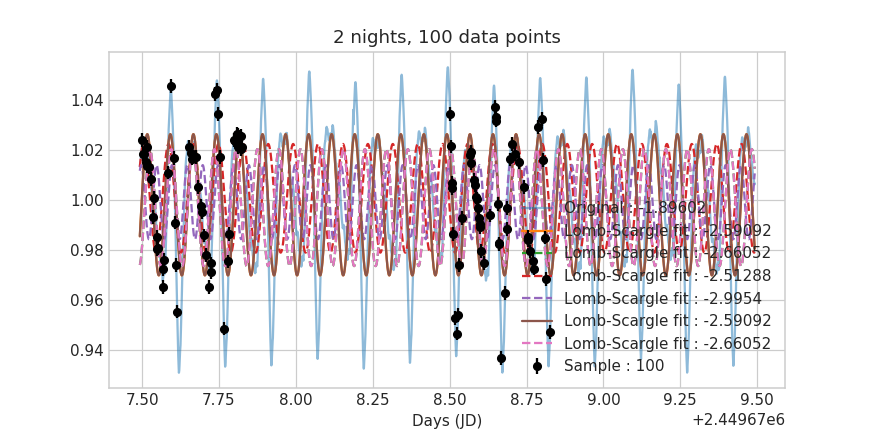

In [5]:
asteroid = '3200'

true_log_p = {'3200':-1.896021, '1291':-1.45813055, 
              '221':-0.8321219, '1388':-0.69789175}
true_p = {'3200':3.603957, '1291':5.58410, 
              '221':10.443, '1388':11.9432}

txt = '../data/'+str(asteroid)+'_lc_49627_to_49787.txt'

data = pd.read_csv(txt, delimiter=' ',
                 header=None, names=['time','flux'], dtype={'time':float, 'flux':float})

days, delay = 2, 50

# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

flux_err = np.ones_like(flux) * np.std(flux)/10.0
tsample, fsample, flux_err = subsample(time, flux, flux_err=flux_err, npoints=100, kind="telescope")

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(time, flux, '-', alpha=0.5, label="Original : " + str(round(true_log_p[asteroid], 5)))
ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, label="Sample : " + str(len(tsample)))
ax.legend()

Let's see what a Lomb-Scargle periodogram predicts the period should be based on our data so far.

<IPython.core.display.Javascript object>


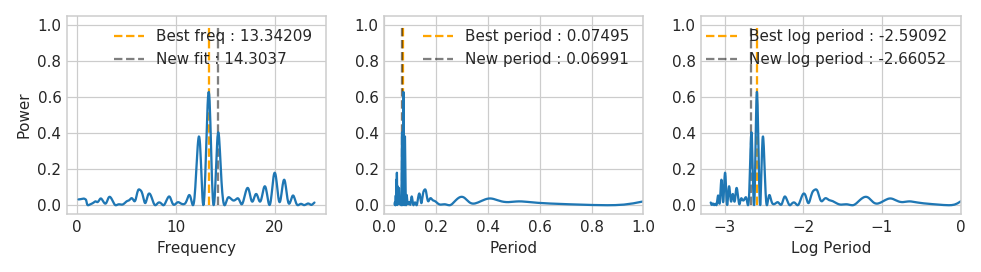

In [17]:
from lombscargle import make_lsp
from astropy.stats import LombScargle

freq, power = make_lsp(tsample, fsample, flux_err, p_max=5.0)

best_freq = freq[np.argmax(power)]
best_period = 1./best_freq
best_log_period = np.log(1./best_freq)

fig, (bx,cx,dx) = plt.subplots(1,3, figsize=(9,2.5))
fig.set_tight_layout('tight')
bx.plot(freq, power)
bx.set_xlabel('Frequency')
bx.set_ylabel('Power')
bx.vlines(best_freq, 0, 1, colors='orange', linestyles='--', 
          label = 'Best freq : ' + str(round(best_freq, 5)))
bx.legend()

cx.plot((1./freq),power)
cx.set_xlabel('Period')
cx.vlines(best_period, 0, 1, colors='orange', linestyles='--', 
          label = 'Best period : ' + str(round(1./best_freq, 5)))
cx.set_xlim([0,1])
cx.legend()

dx.plot(np.log(1./freq),power)
dx.set_xlabel('Log Period')
dx.vlines(np.log(1./best_freq), 0, 1, colors='orange', linestyles='--', 
          label = 'Best log period : ' + str(round(np.log(1./best_freq), 5)))
dx.set_xlim([-3.3,0])
dx.legend()

y_fit = LombScargle(tsample, fsample, flux_err).model(time, best_freq)
ax.plot(time, y_fit, label = "Lomb-Scargle fit : " + str(round(best_log_period, 5)))
ax.legend()

In [18]:
# determine the indices of local power maxima  
best_idx = argrelextrema(power, np.greater)

# sort these indices based on actual power value
# reverse list so max is read first
indices = np.argsort(power[best_idx[0]])[::-1]

# sort our original indices based on the new 
# power-sorted indices
best_idx = (best_idx[0]).T[indices]
best_freqs = freq[best_idx].T

In [19]:
new_freq = best_freqs[1]
new_log_period = np.log(1./new_freq)
y_fit = LombScargle(tsample, fsample, flux_err).model(time, new_freq)
ax.plot(time, y_fit, '--', label = "Lomb-Scargle fit : " + str(round(new_log_period, 5)))
ax.legend()

bx.vlines(new_freq, 0, 1, linestyles='--', alpha=0.5,
          label = 'New fit : ' + str(round(new_freq, 5)))
bx.legend()

cx.vlines(1./new_freq, 0, 1, linestyles='--',  alpha=0.5,
          label = 'New period : ' + str(round(1./new_freq, 5)))
cx.legend()
dx.vlines(new_log_period, 0, 1, linestyles='--',  alpha=0.5,
          label = 'New log period : ' + str(round(new_log_period, 5)))
dx.legend()

How many walkers do we want? So far there are 4 parameters/dimensions we want to study: mean, log_amp, gamma, and log_period.

In [38]:
ndim, nwalkers = 4, 100

In [39]:
# initialize walker parameters
best_log_amp = np.log(flux.max()-flux.min())
params = [np.mean(fsample), best_log_amp, 5, new_log_period]# new_log_period]
p0, gp = walker_params(params, fsample, flux_err, nwalkers, cov_scale=1)
#plot_gpfit(time, fsample, flux_err, gp, ax)

amp : 0.12205999999999996
params : [0.9994147122288288, -2.1032425518657885, 5, -2.660518503990085]
cov matrix : 
[[0.00999415 0.         0.         0.        ]
 [0.         0.02103243 0.         0.        ]
 [0.         0.         0.05       0.        ]
 [0.         0.         0.         0.02660519]]


In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, threads=20)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp

<IPython.core.display.Javascript object>


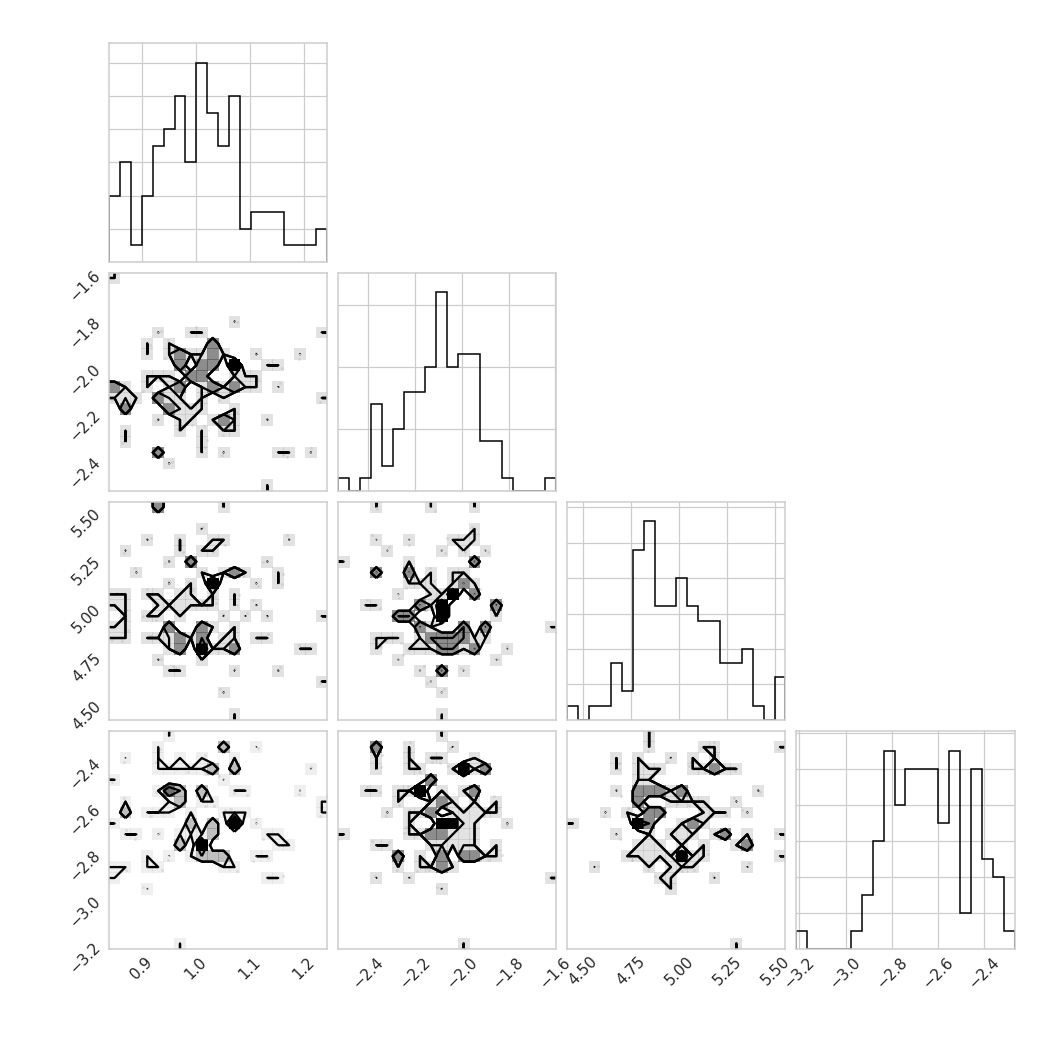

<IPython.core.display.Javascript object>


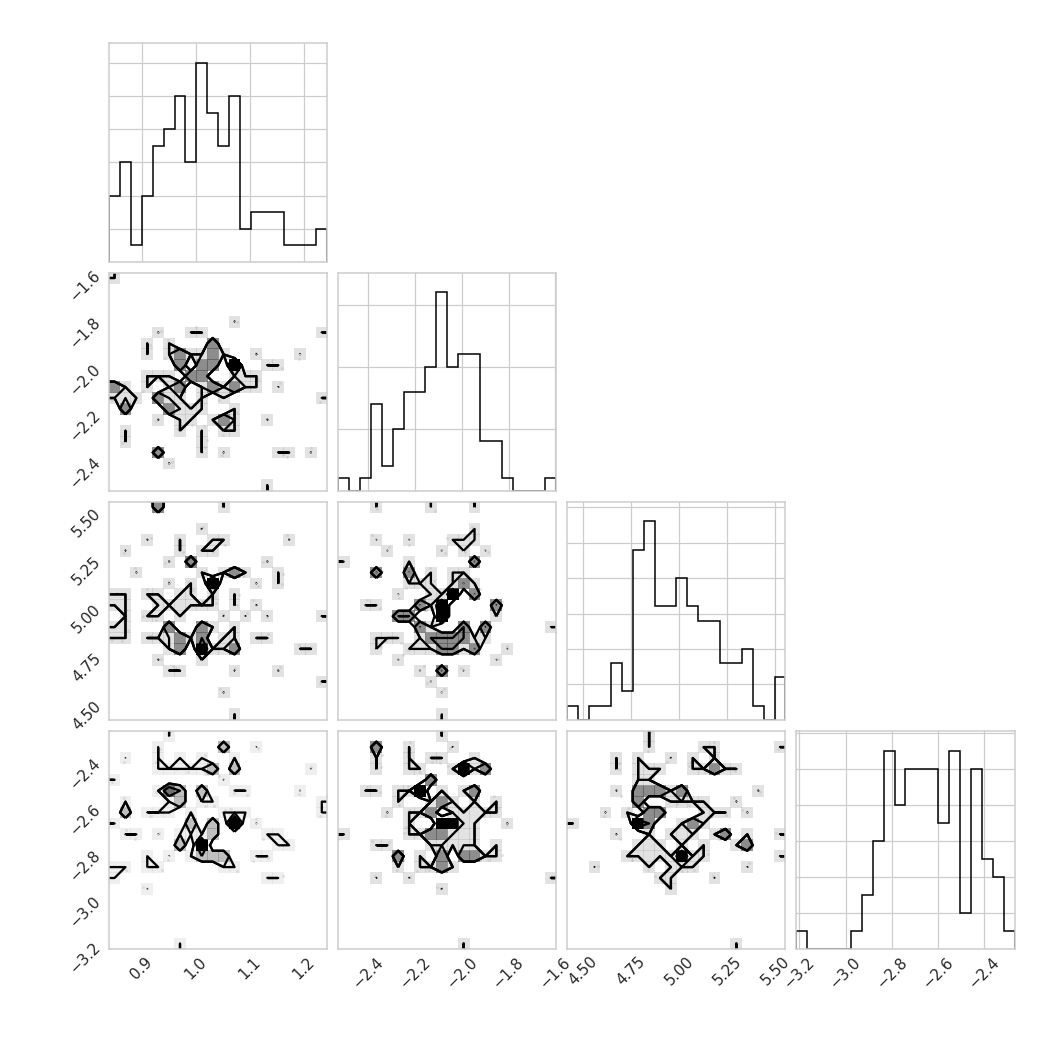

In [42]:
corner.corner(p0)

Note : If your sampler fails within the first couple of seconds, try making the cov_scale smaller.

In [43]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 5000)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


CPU times: user 1min 19s, sys: 24 s, total: 1min 43s
Wall time: 5min 50s


<IPython.core.display.Javascript object>


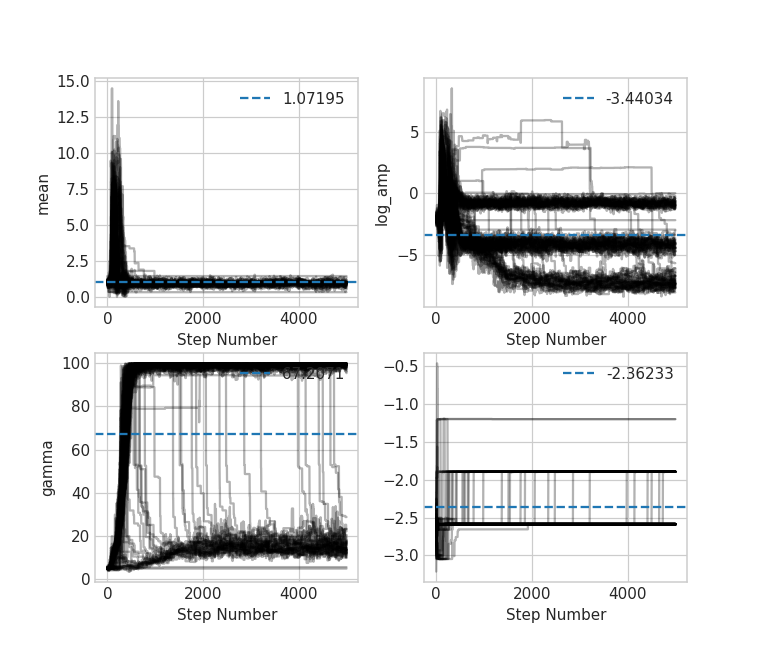

[ 1.01618239 -2.24930997  4.75749087 -2.82627988]
Data points: 100
Mean acceptance fraction: 0.114


In [44]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', ''], p0=p0, data_pts=len(fsample))

<IPython.core.display.Javascript object>


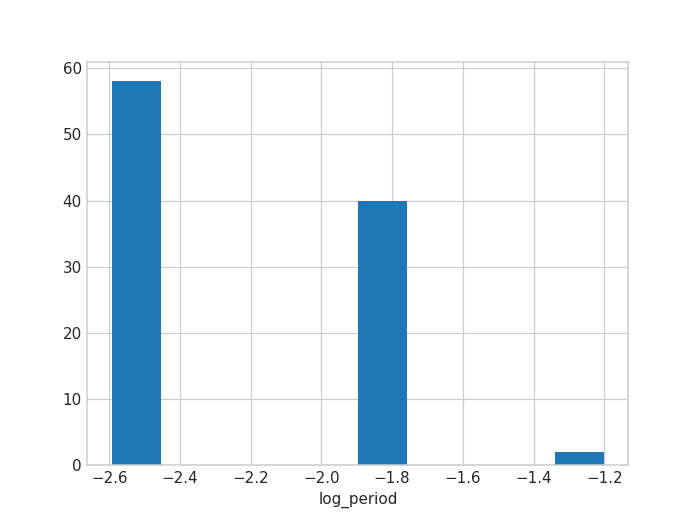

Text(0.5,0,'log_period')

In [46]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(end_period)
fx.set_xlabel('log_period')

In [44]:
def save_chain(data, file_name):
    with file(file_name + '.txt', 'w') as outfile:
        # I'm writing a header here just for the sake of readability
        # Any line starting with "#" will be ignored by numpy.loadtxt
        outfile.write("# " + str(data.shape) + '\n')

        # Iterating through a ndimensional array produces slices along
        # the last axis. This is equivalent to data[i,:,:] in this case
        for data_slice in data:  
            np.savetxt(outfile, data_slice)

            # Writing out a break to indicate different slices...
            outfile.write('# New chain\n')

def read_chain(file_name, shape):
    new_data = np.genfromtxt(file_name + '.txt', delimiter=' ')
    # data shape can be found as the first commented line in the txt file
    new_data = new_data.reshape(shape)
    return new_data


Now we can save our data for later.

In [45]:
save_chain(sampler.chain, 'test')

Or read it out if we want to compare. If you want to plot the saved data, make sure to indicate it when plotting by setting __from_saved__ to True.

In [ ]:
test = read_chain('test', (100,100,4))

In [ ]:
plot_steps(test, dims = ['mean', 'log_amp', 'gamma', 'log_period'], p0=p0, data_pts=len(fsample), from_saved=True)

<IPython.core.display.Javascript object>


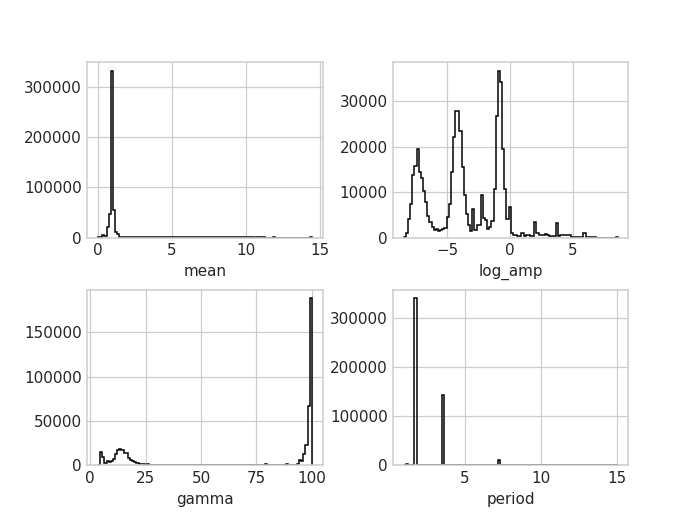

In [48]:
cgp.plot_hist(sampler)

## Evil plotting happening down here.

<IPython.core.display.Javascript object>


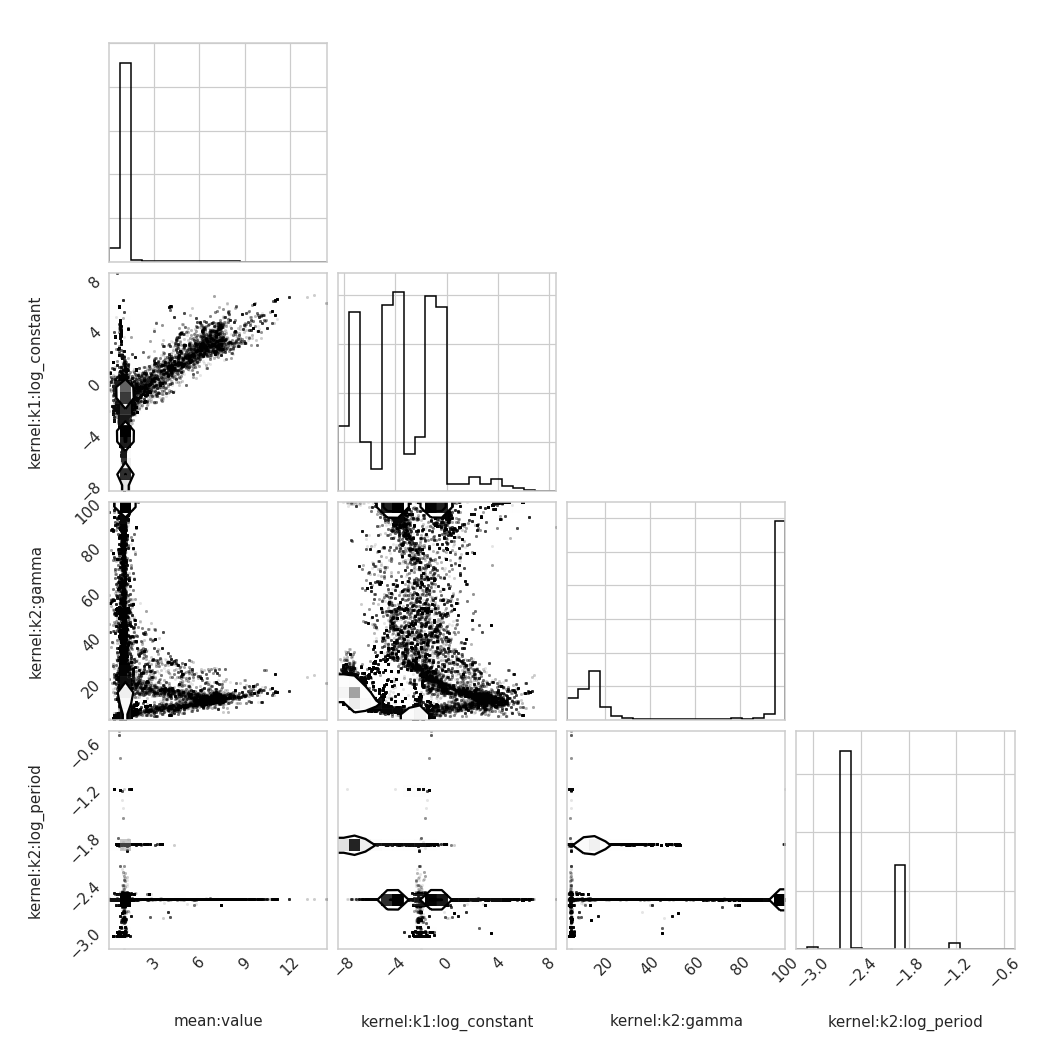

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/george/utils.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


<IPython.core.display.Javascript object>


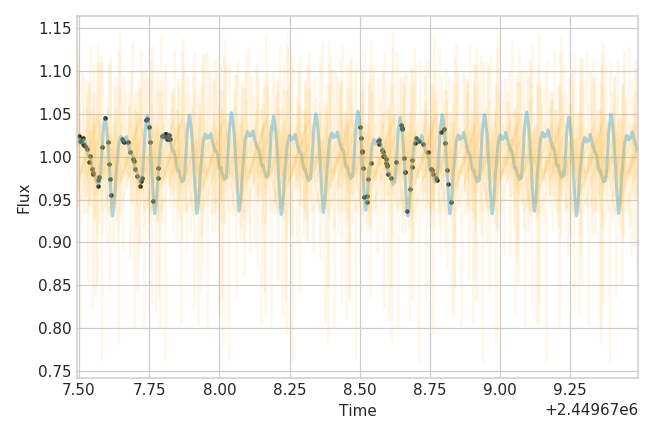

<IPython.core.display.Javascript object>


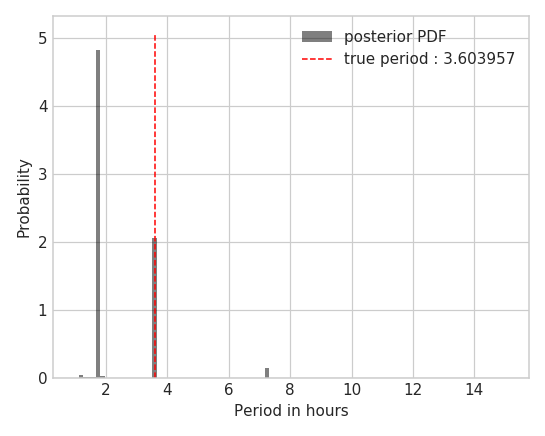

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


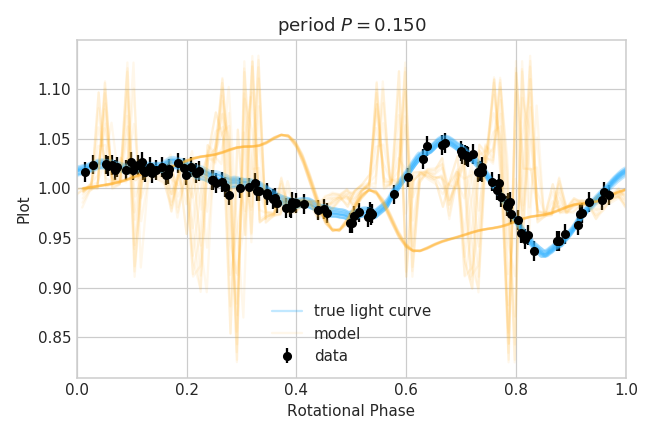

In [47]:
plot_mcmc_sampling_results(tsample, fsample, flux_err, gp, sampler, namestr='test', 
                           true_lightcurve = [time, flux], true_period=true_p[asteroid])

# Misc stuff down here


## Skip the following cell if you are working with simulated data.

Here's an alternative way of doing things if you're working with real data measurements. Since we're working with real data, we are essentially given __tsample__ and __fsample__. So we don't need to sample any points but this also means we don't know what the real light curve looks like. We can still generate a __time__ since it just needs to span from the first observation of __tsample__ to the last.

In [ ]:
txt = '../data/asteroid_csv/2018LF05.csv'
data = pd.read_csv(txt)

tsample = data.jd
fsample = data.magpsf
flux_err = data.sigmapsf
data_pts = len(tsample)

tsample.iloc[-1]

time = pd.Series(np.linspace(tsample.iloc[0], tsample.iloc[-1], 1000))

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.errorbar(tsample, fsample, yerr=flux_err, fmt = 'k.', label="Sample : " + str(len(tsample)))
ax.legend()